### Dask

Dask to biblioteka, która umożliwia równoległe przetwarzanie dużych zbiorów danych, rozdzielając je na mniejsze fragmenty i przetwarzając je równocześnie. Jest szczególnie przydatna w analizie danych przestrzennych, gdzie pliki mogą być zbyt duże, by zmieścić się w pamięci RAM.

Zalety Daska:
- Przetwarzanie równoległe – działa na wielu rdzeniach CPU lub w klastrze obliczeniowym.
- Dynamiczne skalowanie – można pracować zarówno na laptopie, jak i w środowisku rozproszonym.
- Interoperacyjność – współpracuje z Pandas, Xarray, NumPy, a także narzędziami GIS jak rasterio czy rioxarray.
- Lazy evaluation – nie wykonuje obliczeń od razu, tylko buduje graf zadań, który można uruchomić dopiero, gdy jest to potrzebne.

### Rioxarray

Rioxarray to rozszerzenie dla xarray, które dodaje wsparcie dla georeferencyjnych danych rastrowych. Umożliwia:

- łatwe wczytywanie i zapisywanie plików GeoTIFF,
- reprojekcję i analizę przestrzenną,
- interakcję z innymi narzędziami GIS (Rasterio, GDAL).

Rioxarray świetnie integruje się z Daskiem, umożliwiając przetwarzanie ogromnych zbiorów danych rastrowych w sposób efektywny pamięciowo.

In [1]:
from osgeo import gdal
import dask.array as da
import rioxarray as rxr
import dask
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler
from dask.distributed import Client
import pystac_client

### Przeszukiwanie STAC

In [2]:
# Wyszukiwanie w katalogu STAC
stac_url = "https://earth-search.aws.element84.com/v1"
stac_client = pystac_client.Client.open(stac_url)

# Filtrujemy obrazy Sentinel-2 na podstawie lokalizacji i daty
search = stac_client.search(
    collections=["sentinel-2-c1-l2a"],
    bbox=[69.5, 34.0, 70.5, 35.0],  # Przykładowy bbox (Afganistan, zmień na swoje współrzędne)
    datetime="2023-01-06T00:00:00Z/2023-06-22T23:59:59Z",
    max_items=1
)

item = next(search.items(), None)
if not item:
    raise ValueError("Nie znaleziono pasujących obrazów Sentinel-2 w STAC API.")


### Inicjalizacja klienta Dask

In [ ]:
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit="1GB")
client = Client(cluster)
client.get_worker_logs()  # Sprawdzenie logów workerów
display(client)  # Wyświetla link do dashboardu

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63106,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:63118,Total threads: 1
Dashboard: http://127.0.0.1:63120/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:63109,


2025-03-14 18:14:54,471 - distributed.scheduler - WARNING - Worker failed to heartbeat for 828s; attempting restart: <WorkerState 'tcp://127.0.0.1:63118', name: 0, status: running, memory: 0, processing: 0>
2025-03-14 18:14:54,493 - distributed.scheduler - WARNING - Worker failed to heartbeat for 828s; attempting restart: <WorkerState 'tcp://127.0.0.1:63119', name: 1, status: running, memory: 0, processing: 0>
2025-03-14 18:14:55,974 - distributed.nanny - WARNING - Restarting worker
2025-03-14 18:14:56,006 - distributed.nanny - WARNING - Restarting worker
2025-03-14 20:17:53,366 - distributed.scheduler - WARNING - Worker failed to heartbeat for 7193s; attempting restart: <WorkerState 'tcp://127.0.0.1:59107', name: 0, status: running, memory: 0, processing: 0>
2025-03-14 20:17:53,369 - distributed.scheduler - WARNING - Worker failed to heartbeat for 7193s; attempting restart: <WorkerState 'tcp://127.0.0.1:59108', name: 1, status: running, memory: 0, processing: 0>
2025-03-14 20:17:54,91

### Pobranie pliku

In [4]:

# Pobranie linku do pasma czerwonego (B04)
cog_url = item.assets["red"].href

import rasterio
from rasterio.session import AWSSession
import boto3

# Pobierz plik do lokalnego cache
session = AWSSession(boto3.Session(), requester_pays=True)
with rasterio.Env(session):
    raster = rxr.open_rasterio(cog_url, masked=False, chunks="auto", overview_level=0, session=session)
raster = raster.squeeze(dim="band")  # Usuwa wymiar "band" jeśli ma tylko jeden element
raster = raster.chunk({"x": 512, "y": 512}).astype("float32")

In [5]:
raster

<xarray.DataArray (y: 5490, x: 5490)> Size: 121MB
dask.array<astype, shape=(5490, 5490), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 44kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 44kB 3.8e+06 3.8e+06 3.8e+06 ... 3.69e+06 3.69e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

### Podgląd workerów

In [6]:
workers_info = client.scheduler_info()["workers"]
print("Lista workerów Dask:")
for worker, info in workers_info.items():
    memory_used = info.get("metrics", {}).get("memory", "Brak danych")
    nthreads = info.get("nthreads", "Brak danych")
    print(f"Worker: {worker}, Pamięć: {memory_used} B, Aktywne wątki: {nthreads}")

Lista workerów Dask:
Worker: tcp://127.0.0.1:63118, Pamięć: 121352192 B, Aktywne wątki: 1
Worker: tcp://127.0.0.1:63119, Pamięć: 121106432 B, Aktywne wątki: 1


### Normalizacja obrazu

In [7]:
from normalize import normalize_xr

In [71]:
import xarray as xr

def normalize_xr(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

In [9]:
import xarray as xr


In [10]:
normalized_raster = xr.apply_ufunc(normalize_xr, raster, dask='parallelized', output_dtypes=[raster.dtype])

### Uruchomienie przetwarzania

In [12]:
raster = raster.compute()  # Pobiera dane do RAM przed dalszym przetwarzaniem

normalized_raster = (raster - raster.min()) / (raster.max() - raster.min())

2025-03-14 16:36:35,708 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 1 layers.
 0. 2146920665792
>.
Traceback (most recent call last):
  File "c:\ProgramData\miniforge3\envs\daes-env\Lib\site-packages\distributed\protocol\pickle.py", line 60, in dumps
    result = pickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't pickle local object 'lazy_call.<locals>._handler'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\miniforge3\envs\daes-env\Lib\site-packages\distributed\protocol\pickle.py", line 65, in dumps
    pickler.dump(x)
AttributeError: Can't pickle local object 'lazy_call.<locals>._handler'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\miniforge3\envs\daes-env\Lib\site-packages\distributed\protocol\pickle.py", line 77, in dumps
    re

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 1 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x1f3de6e8650>\n 0. 2146920665792\n>')

2025-03-14 16:35:21,121 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 1 layers.
 0. 2146875929152
>.
Traceback (most recent call last):
  File "c:\ProgramData\miniforge3\envs\daes-env\Lib\site-packages\distributed\protocol\pickle.py", line 60, in dumps
    result = pickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't pickle local object 'lazy_call.<locals>._handler'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\miniforge3\envs\daes-env\Lib\site-packages\distributed\protocol\pickle.py", line 65, in dumps
    pickler.dump(x)
AttributeError: Can't pickle local object 'lazy_call.<locals>._handler'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\miniforge3\envs\daes-env\Lib\site-packages\distributed\protocol\pickle.py", line 77, in dumps
    re

TypeError: ('Could not serialize object of type HighLevelGraph', '<ToPickle: HighLevelGraph with 1 layers.\n<dask.highlevelgraph.HighLevelGraph object at 0x1f3dbc91f90>\n 0. 2146875929152\n>')

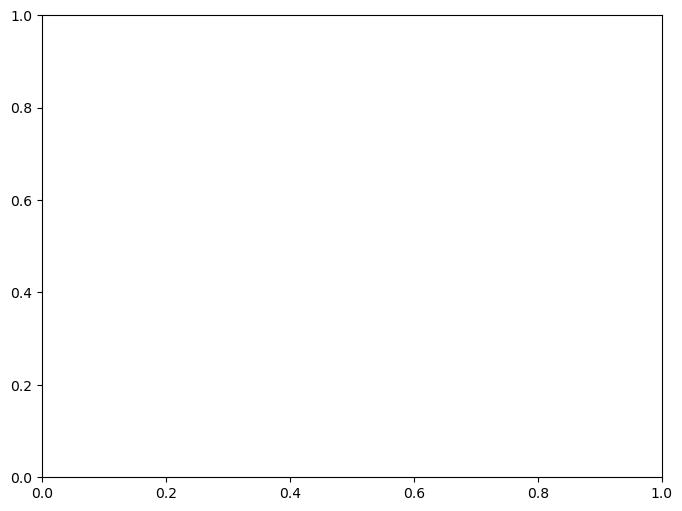

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof, ProgressBar():
    result = normalized_raster.compute()

### Wizualizacja

In [ ]:
ax.imshow(result, cmap="gray")
ax.set_title("Znormalizowane pasmo czerwone Sentinel-2")
plt.show()

### Analiza profilowania

In [ ]:
display(prof.visualize())  # Czas wykonania poszczególnych operacji
display(rprof.visualize()) # Użycie CPU i pamięci
